In [168]:
import pandas as pd
import numpy as np
import pickle
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Dense, Flatten, LSTM, GRU, Embedding,
                                     Dropout, Activation, Bidirectional,
                                     GlobalAveragePooling1D, GlobalMaxPooling1D,
                                     Conv1D, MaxPooling1D)
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (roc_auc_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split


def save_model(model,name):
    json_string = model.to_json()
    open('drive/My Drive/Toxic_Comments/model_files/'+name+'_architecture.json', 'w').write(json_string)
    model.save_weights('drive/My Drive/Toxic_Comments/model_files/'+name+'_weights.h5')
    
def load_model(name):
    model = model_from_json(open('drive/My Drive/Toxic_Comments/model_files/'+name+'_architecture.json').read())
    model.load_weights('drive/My Drive/Toxic_Comments/model_files/'+name+'_weights.h5')
    return(model)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df = pd.read_csv('/content/drive/My Drive/dlaBartka.csv')

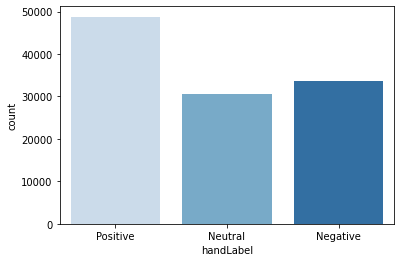

In [118]:
sns.countplot(df.handLabel, palette='Blues')

In [0]:
stopwords = nltk.corpus.stopwords.words('english')
df['tweetsProcessedENGFinalLemmatized'] = df['tweetsProcessedENGFinalLemmatized'].astype(str)
df['clean_tweets'] = df['tweetsProcessedENGFinalLemmatized'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [0]:
# df = df[df.handLabel != 'Neutral']
X = df.tweetsProcessedENGFinalLemmatized
y = pd.get_dummies(df.handLabel).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666)

## Distribution among sets

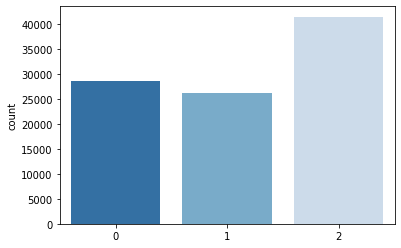

In [117]:
original_back = pd.DataFrame(y_train).idxmax(axis=1)
sns.countplot(original_back, palette='Blues_r')

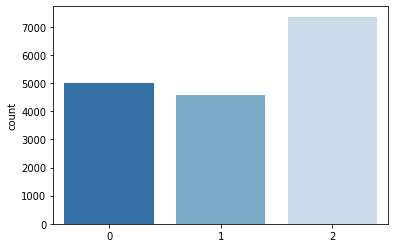

In [115]:
original_back = pd.DataFrame(y_test).idxmax(axis=1)
sns.countplot(original_back, palette='Blues_r')

# Classifier

In [0]:
max_features = 30000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

In [0]:
word_index = tokenizer.word_index
vocab_size=len(word_index)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_length = 300
padding_type='post'
X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type)
X_test = pad_sequences(X_test, maxlen=max_length, padding=padding_type)

In [156]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-04-19 09:05:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   161MB/s    in 2.1s    

2020-04-19 09:05:27 (161 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
model = Sequential([
                    
    Embedding(vocab_size+1, 100, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    Dropout(0.1),

    Conv1D(256, 5),
    MaxPooling1D(pool_size=4),

    Bidirectional(GRU(256, dropout=0.1, return_sequences=True)),
    Dropout(0.1),
    Bidirectional(GRU(256, dropout=0.1, return_sequences=True)),
    GlobalMaxPooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.1),

    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [170]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 100)          3623900   
_________________________________________________________________
dropout_22 (Dropout)         (None, 300, 100)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 296, 256)          128256    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 74, 256)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 74, 512)           789504    
_________________________________________________________________
dropout_23 (Dropout)         (None, 74, 512)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 74, 512)          

In [160]:
epochs = 3
batch_size = 256

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/3
338/338 [==============================] - 33s 99ms/step - loss: 0.9645 - accuracy: 0.5254 - val_loss: 0.9121 - val_accuracy: 0.5627
Epoch 2/3
338/338 [==============================] - 32s 95ms/step - loss: 0.9214 - accuracy: 0.5548 - val_loss: 0.9147 - val_accuracy: 0.5579
Epoch 3/3
338/338 [==============================] - 32s 95ms/step - loss: 0.9037 - accuracy: 0.5676 - val_loss: 0.8959 - val_accuracy: 0.5706


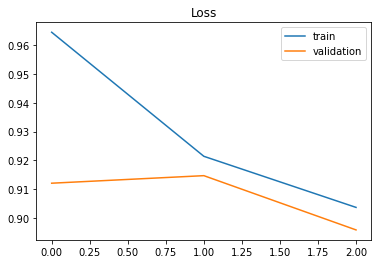

In [161]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();

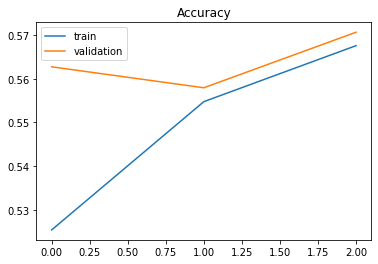

In [162]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

# Evaluation


In [163]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

531/531 [==============================] - 7s 13ms/step - loss: 0.9061 - accuracy: 0.5625
Test set
  Loss: 0.906
  Accuracy: 0.562


In [0]:
y_pred = model.predict(X_test)

In [0]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

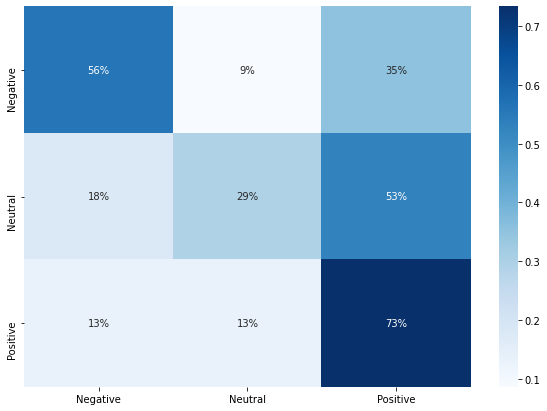

In [166]:
cm_df = pd.DataFrame(cm,
                     index = ['Negative', 'Neutral', 'Positive'], 
                     columns = ['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='.0%', cmap='Blues')

In [167]:
cr = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cr)

              precision    recall  f1-score   support

           0       0.61      0.56      0.58      5019
           1       0.49      0.29      0.37      4589
           2       0.56      0.73      0.64      7357

    accuracy                           0.56     16965
   macro avg       0.55      0.53      0.53     16965
weighted avg       0.56      0.56      0.55     16965

